In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [19]:
df = pd.read_csv('train (1).csv', names=["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pantson fire","context"])

In [20]:
df['label'] = df['label'].replace({
    'pants-fire': 0,
    'FALSE': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'TRUE': 1
})

In [21]:
# Drop unnecessary columns
df = df[['label', 'statement']]

In [22]:
# Preprocess the data

X = df['statement']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Tokenize the text
X_train = [str(x) for x in X_train if isinstance(x, str)]
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
# Pad the sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

In [8]:
# Build the model
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [9]:
print(len(X_train))  # should match the number of samples in y_train
print(len(y_train))

8192
8192


In [10]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
128/128 [==============================] - 6s 34ms/step - loss: 0.8980 - accuracy: 0.5286 - val_loss: 0.6850 - val_accuracy: 0.5664
Epoch 2/50
128/128 [==============================] - 4s 31ms/step - loss: 0.6608 - accuracy: 0.6149 - val_loss: 0.6732 - val_accuracy: 0.5850
Epoch 3/50
128/128 [==============================] - 4s 32ms/step - loss: 0.5385 - accuracy: 0.7438 - val_loss: 0.7313 - val_accuracy: 0.5996
Epoch 4/50
128/128 [==============================] - 4s 30ms/step - loss: 0.3317 - accuracy: 0.8722 - val_loss: 0.8615 - val_accuracy: 0.5811
Epoch 5/50
128/128 [==============================] - 4s 30ms/step - loss: 0.1434 - accuracy: 0.9598 - val_loss: 1.0826 - val_accuracy: 0.5737


In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Test score:', loss)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Test score: 1.082639455795288
Testing Accuracy:  0.5737


In [12]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

64/64 [==============================] - 1s 6ms/step


In [13]:
print(y_test.shape)
print(y_pred.shape)

(2048,)
(2048, 6)


In [14]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49       888
           1       0.62      0.65      0.63      1160

    accuracy                           0.57      2048
   macro avg       0.56      0.56      0.56      2048
weighted avg       0.57      0.57      0.57      2048



Confusion Matrix:
[[426 462]
 [411 749]]


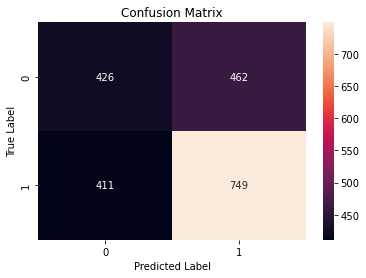

In [15]:
cm = confusion_matrix(y_test, y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

AUC: 0.563


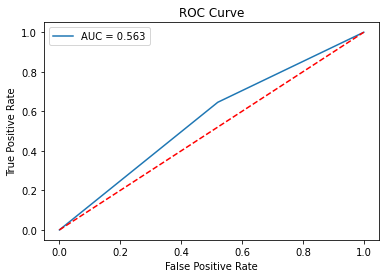

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)
print(f'AUC: {auc:.3f}')
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()